In [1]:
from cassiemujocoik_ctypes import *
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import array
import numpy as np
import pickle
import os

In [2]:
class CassieIK(object):
    def __init__(self, sim_steps=1, render_sim=False):
        self.sim = mujSimulation(render_sim)
        self.sim_steps = sim_steps
        self.render_sim = render_sim
        # qpos we want as output from ik
        self.qpos = array.array('d', [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        self.qpos = (ctypes.c_double * 35) (*self.qpos)

    def single_pos_ik(self, traj_pos):
        # foot position we want to go to
        traj_pos_arr = array.array('d', traj_pos)
        # convert foot positions to c array
        traj_pos_arr_c = (ctypes.c_double * 9) (*traj_pos_arr)

        # use wrapper to get ik
        qpos = self.sim.fetch_cassie_ik(traj_pos_arr_c, steps=self.sim_steps)

        return np.array(qpos[:35])
    
    def trajectory_ik(self, trajectory):
        traj_qpos = np.zeros((len(trajectory), 35))
        for i in range(len(trajectory)):
            traj_qpos[i] += self.single_pos_ik(trajectory[i])
        
        # Now we gotta estimate the qvels using finite difference estimates of d qpos / dt
        # only do this for the motor positions
        motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]
        traj_qvel = np.zeros((len(trajectory), len(motor_indices)))
        for i in range(len(traj_qpos)):
            traj_qvel[i] += np.take((traj_qpos[i] - traj_qpos[i - 1]) / (1/2000), motor_indices)

        full_trajectory = {"qpos": traj_qpos, "qvel": traj_qvel}
        with open("trajectory/spline_stepping_traj.pkl", "wb") as f:
            pickle.dump(full_trajectory, f)
            print("wrote pickle file")
            
        return traj_qpos, traj_qvel
    
    # version of above function for trajectories from aslip rom
    def rom_trajectory_ik_interpolate(self, spline_params, step_size=0.001, speedup = 3):
        
        # calculate length based on step_size
        points = np.arange(0, 1, step_size * speedup)
        new_points = np.transpose(np.array(splev(points, spline_params)))
        print("New points shape = {}".format(new_points.shape))
        length = points.shape[0]
        
        traj_qpos = np.zeros((length, 35))
        
        # variables to hold current phase, time, integer index counter
        time = 0
        
        for i in range(length):    
            # pass traj data from spline into ik
            traj_qpos[i] += self.single_pos_ik(new_points[i])
            # increment time
            time += step_size * speedup
            # debug
            print("time: {}  idx: {}".format(time, i))
            
        # Now we gotta estimate the qvels using finite difference estimates of d qpos / dt
        # only do this for the motor positions
        motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]
        traj_qvel = np.zeros((length, len(motor_indices)))
        for i in range(len(traj_qpos)):
            traj_qvel[i] += np.take((traj_qpos[i] - traj_qpos[i - 1]) / (step_size * speedup), motor_indices)

            
        print(new_points[:,0:3].shape)
        # calculate distance between feet and center of mass, append to trajectory info
        right_dist = np.linalg.norm(new_points[:,0:3] - new_points[:,6:9], axis=1)
        print(right_dist.shape)
        left_dist = np.linalg.norm(new_points[:,3:6] - new_points[:,6:9], axis=1)
        print(left_dist.shape)
        print(traj_qpos.shape)
            
        return traj_qpos, traj_qvel, right_dist, left_dist

In [3]:
def get_trajectory_from_rom_data():
    data = np.load("rom_traj_data.npy")
    return data

(9, 392)
(9, 392)
(0, 392)


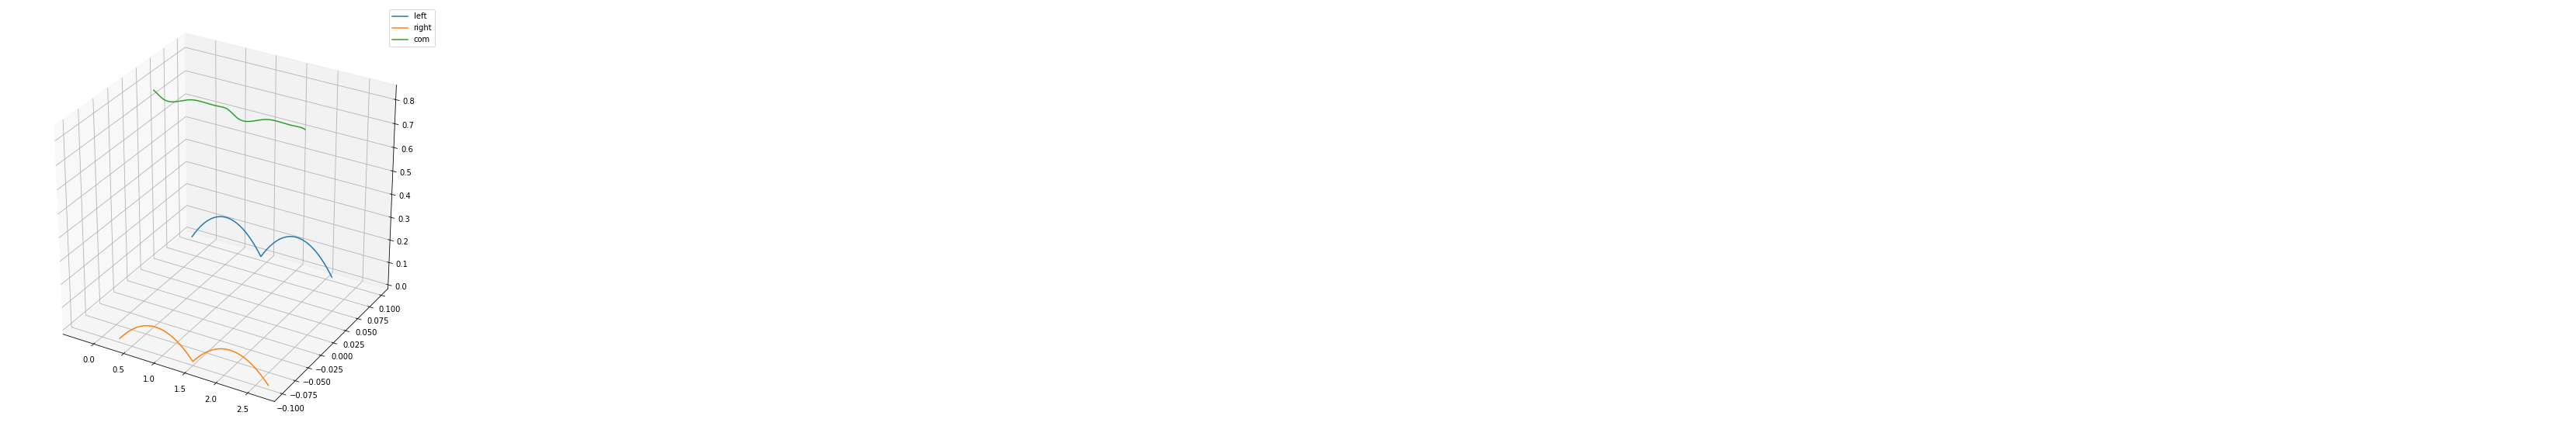

New points shape = (1667, 9)
time: 0.0006000000000000001  idx: 0
time: 0.0012000000000000001  idx: 1
time: 0.0018000000000000002  idx: 2
time: 0.0024000000000000002  idx: 3
time: 0.003  idx: 4
time: 0.0036  idx: 5
time: 0.0042  idx: 6
time: 0.0048  idx: 7
time: 0.005399999999999999  idx: 8
time: 0.005999999999999999  idx: 9
time: 0.006599999999999999  idx: 10
time: 0.007199999999999999  idx: 11
time: 0.007799999999999999  idx: 12
time: 0.0084  idx: 13
time: 0.009  idx: 14
time: 0.0096  idx: 15
time: 0.010199999999999999  idx: 16
time: 0.010799999999999999  idx: 17
time: 0.011399999999999999  idx: 18
time: 0.011999999999999999  idx: 19
time: 0.012599999999999998  idx: 20
time: 0.013199999999999998  idx: 21
time: 0.013799999999999998  idx: 22
time: 0.014399999999999998  idx: 23
time: 0.014999999999999998  idx: 24
time: 0.015599999999999998  idx: 25
time: 0.0162  idx: 26
time: 0.0168  idx: 27
time: 0.0174  idx: 28
time: 0.018  idx: 29
time: 0.0186  idx: 30
time: 0.0192  idx: 31
time: 0.01

time: 0.1428000000000002  idx: 237
time: 0.1434000000000002  idx: 238
time: 0.14400000000000018  idx: 239
time: 0.14460000000000017  idx: 240
time: 0.14520000000000016  idx: 241
time: 0.14580000000000015  idx: 242
time: 0.14640000000000014  idx: 243
time: 0.14700000000000013  idx: 244
time: 0.14760000000000012  idx: 245
time: 0.1482000000000001  idx: 246
time: 0.1488000000000001  idx: 247
time: 0.1494000000000001  idx: 248
time: 0.15000000000000008  idx: 249
time: 0.15060000000000007  idx: 250
time: 0.15120000000000006  idx: 251
time: 0.15180000000000005  idx: 252
time: 0.15240000000000004  idx: 253
time: 0.15300000000000002  idx: 254
time: 0.15360000000000001  idx: 255
time: 0.1542  idx: 256
time: 0.1548  idx: 257
time: 0.15539999999999998  idx: 258
time: 0.15599999999999997  idx: 259
time: 0.15659999999999996  idx: 260
time: 0.15719999999999995  idx: 261
time: 0.15779999999999994  idx: 262
time: 0.15839999999999993  idx: 263
time: 0.15899999999999992  idx: 264
time: 0.159599999999999

time: 0.28319999999999773  idx: 471
time: 0.2837999999999977  idx: 472
time: 0.2843999999999977  idx: 473
time: 0.2849999999999977  idx: 474
time: 0.2855999999999977  idx: 475
time: 0.2861999999999977  idx: 476
time: 0.28679999999999767  idx: 477
time: 0.28739999999999766  idx: 478
time: 0.28799999999999765  idx: 479
time: 0.28859999999999764  idx: 480
time: 0.2891999999999976  idx: 481
time: 0.2897999999999976  idx: 482
time: 0.2903999999999976  idx: 483
time: 0.2909999999999976  idx: 484
time: 0.2915999999999976  idx: 485
time: 0.2921999999999976  idx: 486
time: 0.29279999999999756  idx: 487
time: 0.29339999999999755  idx: 488
time: 0.29399999999999754  idx: 489
time: 0.29459999999999753  idx: 490
time: 0.2951999999999975  idx: 491
time: 0.2957999999999975  idx: 492
time: 0.2963999999999975  idx: 493
time: 0.2969999999999975  idx: 494
time: 0.2975999999999975  idx: 495
time: 0.29819999999999747  idx: 496
time: 0.29879999999999746  idx: 497
time: 0.29939999999999745  idx: 498
time: 0.

time: 0.42299999999999527  idx: 704
time: 0.42359999999999526  idx: 705
time: 0.42419999999999525  idx: 706
time: 0.42479999999999524  idx: 707
time: 0.4253999999999952  idx: 708
time: 0.4259999999999952  idx: 709
time: 0.4265999999999952  idx: 710
time: 0.4271999999999952  idx: 711
time: 0.4277999999999952  idx: 712
time: 0.4283999999999952  idx: 713
time: 0.42899999999999516  idx: 714
time: 0.42959999999999515  idx: 715
time: 0.43019999999999514  idx: 716
time: 0.43079999999999513  idx: 717
time: 0.4313999999999951  idx: 718
time: 0.4319999999999951  idx: 719
time: 0.4325999999999951  idx: 720
time: 0.4331999999999951  idx: 721
time: 0.4337999999999951  idx: 722
time: 0.43439999999999507  idx: 723
time: 0.43499999999999506  idx: 724
time: 0.43559999999999505  idx: 725
time: 0.43619999999999504  idx: 726
time: 0.436799999999995  idx: 727
time: 0.437399999999995  idx: 728
time: 0.437999999999995  idx: 729
time: 0.438599999999995  idx: 730
time: 0.439199999999995  idx: 731
time: 0.43979

time: 0.5633999999999987  idx: 938
time: 0.5639999999999987  idx: 939
time: 0.5645999999999988  idx: 940
time: 0.5651999999999988  idx: 941
time: 0.5657999999999989  idx: 942
time: 0.5663999999999989  idx: 943
time: 0.566999999999999  idx: 944
time: 0.567599999999999  idx: 945
time: 0.568199999999999  idx: 946
time: 0.5687999999999991  idx: 947
time: 0.5693999999999991  idx: 948
time: 0.5699999999999992  idx: 949
time: 0.5705999999999992  idx: 950
time: 0.5711999999999993  idx: 951
time: 0.5717999999999993  idx: 952
time: 0.5723999999999994  idx: 953
time: 0.5729999999999994  idx: 954
time: 0.5735999999999994  idx: 955
time: 0.5741999999999995  idx: 956
time: 0.5747999999999995  idx: 957
time: 0.5753999999999996  idx: 958
time: 0.5759999999999996  idx: 959
time: 0.5765999999999997  idx: 960
time: 0.5771999999999997  idx: 961
time: 0.5777999999999998  idx: 962
time: 0.5783999999999998  idx: 963
time: 0.5789999999999998  idx: 964
time: 0.5795999999999999  idx: 965
time: 0.580199999999999

time: 0.7038000000000092  idx: 1172
time: 0.7044000000000092  idx: 1173
time: 0.7050000000000093  idx: 1174
time: 0.7056000000000093  idx: 1175
time: 0.7062000000000094  idx: 1176
time: 0.7068000000000094  idx: 1177
time: 0.7074000000000095  idx: 1178
time: 0.7080000000000095  idx: 1179
time: 0.7086000000000096  idx: 1180
time: 0.7092000000000096  idx: 1181
time: 0.7098000000000096  idx: 1182
time: 0.7104000000000097  idx: 1183
time: 0.7110000000000097  idx: 1184
time: 0.7116000000000098  idx: 1185
time: 0.7122000000000098  idx: 1186
time: 0.7128000000000099  idx: 1187
time: 0.7134000000000099  idx: 1188
time: 0.71400000000001  idx: 1189
time: 0.71460000000001  idx: 1190
time: 0.71520000000001  idx: 1191
time: 0.7158000000000101  idx: 1192
time: 0.7164000000000101  idx: 1193
time: 0.7170000000000102  idx: 1194
time: 0.7176000000000102  idx: 1195
time: 0.7182000000000103  idx: 1196
time: 0.7188000000000103  idx: 1197
time: 0.7194000000000104  idx: 1198
time: 0.7200000000000104  idx: 119

time: 0.8442000000000197  idx: 1406
time: 0.8448000000000198  idx: 1407
time: 0.8454000000000198  idx: 1408
time: 0.8460000000000198  idx: 1409
time: 0.8466000000000199  idx: 1410
time: 0.8472000000000199  idx: 1411
time: 0.84780000000002  idx: 1412
time: 0.84840000000002  idx: 1413
time: 0.8490000000000201  idx: 1414
time: 0.8496000000000201  idx: 1415
time: 0.8502000000000202  idx: 1416
time: 0.8508000000000202  idx: 1417
time: 0.8514000000000203  idx: 1418
time: 0.8520000000000203  idx: 1419
time: 0.8526000000000203  idx: 1420
time: 0.8532000000000204  idx: 1421
time: 0.8538000000000204  idx: 1422
time: 0.8544000000000205  idx: 1423
time: 0.8550000000000205  idx: 1424
time: 0.8556000000000206  idx: 1425
time: 0.8562000000000206  idx: 1426
time: 0.8568000000000207  idx: 1427
time: 0.8574000000000207  idx: 1428
time: 0.8580000000000207  idx: 1429
time: 0.8586000000000208  idx: 1430
time: 0.8592000000000208  idx: 1431
time: 0.8598000000000209  idx: 1432
time: 0.8604000000000209  idx: 1

time: 0.9846000000000302  idx: 1640
time: 0.9852000000000303  idx: 1641
time: 0.9858000000000303  idx: 1642
time: 0.9864000000000304  idx: 1643
time: 0.9870000000000304  idx: 1644
time: 0.9876000000000305  idx: 1645
time: 0.9882000000000305  idx: 1646
time: 0.9888000000000305  idx: 1647
time: 0.9894000000000306  idx: 1648
time: 0.9900000000000306  idx: 1649
time: 0.9906000000000307  idx: 1650
time: 0.9912000000000307  idx: 1651
time: 0.9918000000000308  idx: 1652
time: 0.9924000000000308  idx: 1653
time: 0.9930000000000309  idx: 1654
time: 0.9936000000000309  idx: 1655
time: 0.994200000000031  idx: 1656
time: 0.994800000000031  idx: 1657
time: 0.995400000000031  idx: 1658
time: 0.9960000000000311  idx: 1659
time: 0.9966000000000311  idx: 1660
time: 0.9972000000000312  idx: 1661
time: 0.9978000000000312  idx: 1662
time: 0.9984000000000313  idx: 1663
time: 0.9990000000000313  idx: 1664
time: 0.9996000000000314  idx: 1665
time: 1.0002000000000313  idx: 1666
(1667, 3)
(1667,)
(1667,)
(1667

In [4]:
from mpl_toolkits.mplot3d import Axes3D

#task_trajectory = get_trajectory_from_ref_foot_pos()
#task_trajectory = get_trajectory_from_cubic_spline(.2, 1.0, 825)

rom_trajectory = get_trajectory_from_rom_data() # last row of this data is the time information
print(rom_trajectory.shape)
task_trajectory = rom_trajectory[0:9]
print(task_trajectory.shape)


# generate splines out of task trajecotry
from scipy.interpolate import splprep, splev

tck, u = splprep(task_trajectory, s=0)
new_points = splev(u, tck)

task_trajectory_time = rom_trajectory[9:]
print(task_trajectory_time.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(task_trajectory[0,:],task_trajectory[1,:],task_trajectory[2,:], label='left')
ax.plot(task_trajectory[3,:],task_trajectory[4,:],task_trajectory[5,:], label='right')
ax.plot(task_trajectory[6,:],task_trajectory[7,:],task_trajectory[8,:], label='com')
ax.legend()
plt.show()

cassie = CassieIK(sim_steps=1, render_sim=True)
traj_qpos, traj_qvel, right_dist, left_dist = cassie.rom_trajectory_ik_interpolate(tck, step_size=0.0001, speedup=6)


full_trajectory = {"qpos": traj_qpos[(traj_qpos.shape[0] // 2):] \
                   , "qvel": traj_qvel[(traj_qvel.shape[0] // 2):] \
                   , "rfoot": right_dist[(right_dist.shape[0] // 2):] \
                   , "lfoot": left_dist[(left_dist.shape[0] // 2):]}
with open("trajectory/30hz_aslip_trajs.pkl", "wb") as f:
    pickle.dump(full_trajectory, f)
    print("wrote pickle file")

In [5]:
traj_qpos.shape

(1667, 35)

In [ ]:
# Stack data together

print(traj_qpos.shape)

output = np.transpose(np.vstack((sin, cos)))
output = np.hstack((output[(output.shape[0] // 2): , :], traj_qpos[(traj_qpos.shape[0] // 2): , :], traj_qvel[(traj_qvel.shape[0] // 2): , :]))
print(output.shape)

# write to output file
np.save('trajectory/rom_ik_traj_data.npy',output)

In [ ]:
fig = plt.figure(figsize=(12,10))
qposes = fig.add_subplot(111)
#qposes.plot(output[:,:37])
qposes.plot(np.rad2deg(traj_qpos[:,34]))
qposes.plot(np.rad2deg(traj_qpos[:,20]))

plt.show()

In [ ]:
fig2 = plt.figure(figsize=(12,10))
qvels = fig2.add_subplot(111)
qvels.plot(traj_qvel)
qvels.legend(np.arange(10))
plt.show()

In [ ]:
from trajectory import CassieTrajectory
traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")

In [ ]:
# Get actual qpos
motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]

# Plot alongside the IK ones
plt.figure(1, figsize=(12,10))
ik = plt.subplot(211)
plt.plot(traj_qpos[:,np.array(motor_indices)])
plt.legend(np.arange(10))
real = plt.subplot(212)
plt.plot(traj.qpos[:,np.array(motor_indices)])
plt.legend(np.arange(10))
plt.show()




In [ ]:
# Get actual qvels
from trajectory import CassieTrajectory
traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")
motor_indices = [6, 7, 8, 12, 18, 19, 20, 21, 25, 31]
real_qvels = traj.qvel[:,np.array(motor_indices)]

# Plot alongside the calculated ones
plt.figure(1, figsize=(12,10))
calc = plt.subplot(211)
plt.plot(traj_qvel)
plt.legend(np.arange(10))
real = plt.subplot(212)
plt.plot(real_qvels)
plt.legend(np.arange(10))
real.set_xlim(calc.get_xlim())
real.set_ylim(calc.get_ylim())
plt.show()


In [ ]:
# # From cubic spline for now
# from scipy.interpolate import CubicSpline

# def get_trajectory_from_cubic_spline(peak, stride, phase, stance=0.15):
#     """
#     Foot and center of mass trajectory generator

#     The center of mass trajectory is a line q(t) = (x(t), 0, z). 

#     The foot trajectories are periodic 3 point cubic splines in z(t),
#     lines in x(t), and constant in y => q(t) = (x(t), y, z(t))

#     Left and right foot trajectories are offset in time by "phase" timesteps.
#     """
#     # TODO: figure out formula for how com_vel relates to foot trajectories...
#     # is SLIP model necessary?
#     com_vel = 0.02

#     t = np.arange(phase)

#     m = stride / phase

#     ts = np.array([0, phase / 2, phase - 1])
#     zs = np.array([0, peak, 0])
#     spline = CubicSpline(ts, zs)

#     x = m * t
#     z = spline(t)
    
#     # left foot steps first
#     x_l = np.concatenate((x, np.ones(phase) * x[-1]))
#     y_l = np.ones(phase * 2) * -stance
#     z_l = np.concatenate((z, np.zeros(phase)))

#     # then right foot
#     x_r = np.concatenate((np.ones(phase) * x[0] + stride / 2, x + stride / 2))
#     y_r = np.ones(phase * 2) * stance
#     z_r = np.concatenate((np.zeros(phase), z))

#     x_com = np.cumsum(np.ones(phase * 2) * com_vel)
#     y_com = np.zeros(phase * 2)
#     z_com = np.ones(phase * 2) * 1

#     return np.column_stack([x_l, y_l, z_l, 
#                        x_r, y_r, z_r, 
#                        x_com, y_com, z_com])

In [ ]:
# def get_trajectory_from_ref_foot_pos():
#     from trajectory import CassieTrajectory
#     traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")

#     os.path.abspath('')
#     foot_pos = traj.foot_pos
#     foot_vel = traj.foot_vel

#     com_vel = 0.02

#     pelvis_height = 1

#     # pelvis coordinates
#     x_com = traj.qpos[:,0]
#     y_com = traj.qpos[:,1]
#     z_com = traj.qpos[:,2]

#     # left foot steps first
#     x_l = foot_pos[:,0] + x_com
#     y_l = foot_pos[:,1] + y_com
#     z_l = foot_pos[:,2] + z_com

#     # then right foot
#     x_r = foot_pos[:,3] + x_com
#     y_r = foot_pos[:,4] + y_com
#     z_r = foot_pos[:,5] + z_com

#     return np.column_stack([x_l, y_l, z_l, 
#                        x_r, y_r, z_r, 
#                        x_com, y_com, z_com])

In [ ]:
# Finally, let's create a clock to add to final data.

def generate_clock(data_len):
    x = np.arange(0, 2 * np.pi, 2*np.pi / data_len)
    return np.sin(x), np.cos(x)

sin, cos = generate_clock(traj_qpos.shape[0])

# plots of individual rows
fig = plt.figure()
ax = fig.add_subplot(111)

# graph sin, cos
ax.plot(sin,label='sin')
ax.plot(cos,label='cos')
ax.legend()

plt.show()